In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display
import spacy
import re
import unicodedata
from housing_project.notebooks.duckdb_handler import DatabaseConnection
import numpy as np

nlp = spacy.load('pt_core_news_sm')

db = DatabaseConnection('./house_prices.db')
with db.managed_cursor() as con:
    result = con.execute("SELECT * FROM idealista")
    # Fetch the results
    data = result.fetchdf()

display(data.head(5))

,title,home_type,link,garage,price,additional_details,description,home_size,home_area,floor,elevator,price_per_sqr_meter
0,Apartamento T1 na rua Augusto Maria da Silveir...,Apartamento,https://www.idealista.pt/imovel/32858752/,No,280,"[T1, 30 m² área bruta, 3º andar sem elevador, ...",APARTAMENTO T1 (águas-furtadas) em Almada.\nDE...,T1,30,3.0,0,9.333333
1,"Apartamento T2 na rua Cândido Capilé, 2, Almada",Apartamento,https://www.idealista.pt/imovel/33394855/,No,800,"[T2, 57 m² área bruta, sem elevador, 20 horas]",Apartamento com 3 assoalhadas localizado no ce...,T2,57,0.0,0,14.035088
2,"Apartamento T0 na rua Eleutério Teixeira, 8, C...",Apartamento,https://www.idealista.pt/imovel/33394837/,No,1000,"[T0, 50 m² área bruta, Rés do chão sem elevado...","Estúdio com muita luz, casa de banho com duche...",T0,50,0.0,0,20.000000
3,"Apartamento T3 na avenida do Oceano, 22, Santo...",Apartamento,https://www.idealista.pt/imovel/33394832/,No,1600,"[T3, 100 m² área bruta, 4º andar com elevador,...","O apartamento tem 3 quartos, 1 deles tem cama ...",T3,100,4.0,1,16.000000
4,Apartamento T1 em Almada,Apartamento,https://www.idealista.pt/imovel/33394381/,No,918,"[T1, 55 m² área bruta, Rés do chão sem elevado...",Apartamento de tipologia T1 em prédio totalmen...,T1,55,0.0,0,16.690908


In [ ]:
numeric_cols = ["price_per_sqr_meter_bin", "price", "home_area", "foor"]

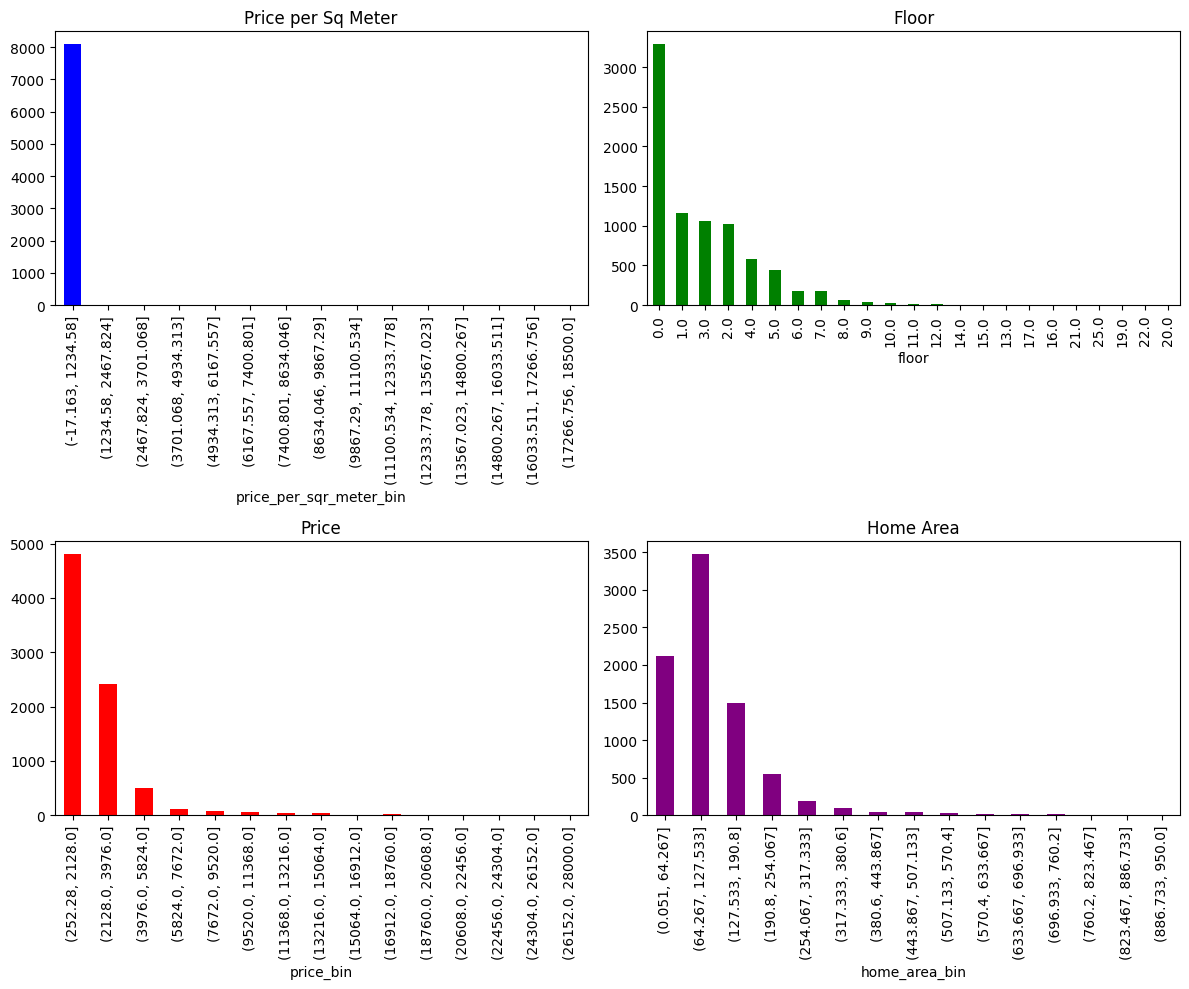

In [ ]:
import matplotlib.pyplot as plt

def plot_numeric(data, nbins = 15):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed

    # Plot for price_per_sqr_meter
    data['price_per_sqr_meter_bin'] = pd.cut(data['price_per_sqr_meter'], bins=nbins)  # Binning into 5 categories
    data['price_per_sqr_meter_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='blue', title='Price per Sq Meter')

    # Plot for floor
    data['floor'].value_counts().plot(kind='bar', ax=axes[0, 1], color='green', title='Floor')

    # Plot for price
    data['price_bin'] = pd.cut(data['price'], bins=nbins)  # Binning into 5 categories
    data['price_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='red', title='Price')

    # Plot for home_area
    data['home_area_bin'] = pd.cut(data['home_area'], bins=nbins)  # Binning into 5 categories
    data['home_area_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='purple', title='Home Area')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_numeric(data, nbins = 25)

In [ ]:
# remove houses bigger than T6, does not make sense for the analysis
data = data[data["home_size"].isin(["T0", "T1", "T2", "T3", "T4", "T5", "T6"])]

In [ ]:
original_len = len(data)

def filter_city_group(group):
    # Calculate quantiles within each group
    c1 = group['price_per_sqr_meter'].quantile(0.99)
    c2 = group['price'].quantile(0.99)
    c3 = group['home_area'].quantile(0.99)
    
    # Filter based on the upper quantiles
    filtered_group = group[(group['price_per_sqr_meter'] <= c1) & 
                           (group['price'] <= c2) & 
                           (group['home_area'] <= c3)]
    
    # Calculate the lower quantile for price_per_sqr_meter
    c4 = filtered_group['price_per_sqr_meter'].quantile(0.025)
    
    # Further filter the group
    final_filtered_group = filtered_group[filtered_group['price_per_sqr_meter'] > c4]
    
    return final_filtered_group

data = data.groupby(['city', 'home_size']).apply(filter_city_group).reset_index(drop=True)

In [ ]:
print(f'{original_len- len(data)} rows were removed. \n Original df: {original_len}\n Filtered df: {len(data)} \n Dataframe size is {original_len/len(data)*100}')

729 rows were removed. 
 Original df: 8056
 Filtered df: 7327


In [ ]:
# we can also define some business rules based on fixed values
# as long as the values have some ground of truth
"""original_len = len(data)

c1 = data['price_per_sqr_meter'].quantile(0.95) # 50 € per sqr meter is also crazy
c2 = data['price'].quantile(0.95)
c3 = data['home_area'].quantile(0.95) # makes no sense to consider a house with less than 20m2
data = data[(data['price_per_sqr_meter'] <= c1) & 
            (data['price'] <= c2) & 
            (data['home_area'] <= c3)]

c4 = data['price_per_sqr_meter'].quantile(0.05)
data = data[data['price_per_sqr_meter'] > c4]
display(data.describe())"""

"original_len = len(data)\n\nc1 = data['price_per_sqr_meter'].quantile(0.95) # 50 € per sqr meter is also crazy\nc2 = data['price'].quantile(0.95)\nc3 = data['home_area'].quantile(0.95) # makes no sense to consider a house with less than 20m2\ndata = data[(data['price_per_sqr_meter'] <= c1) & \n            (data['price'] <= c2) & \n            (data['home_area'] <= c3)]\n\nc4 = data['price_per_sqr_meter'].quantile(0.05)\ndata = data[data['price_per_sqr_meter'] > c4]\ndisplay(data.describe())"

In [ ]:
print(f'{original_len- len(data)} rows were removed. \n Original df: {original_len}\n Filtered df: {len(data)}')

729 rows were removed. 
 Original df: 8056
 Filtered df: 7327


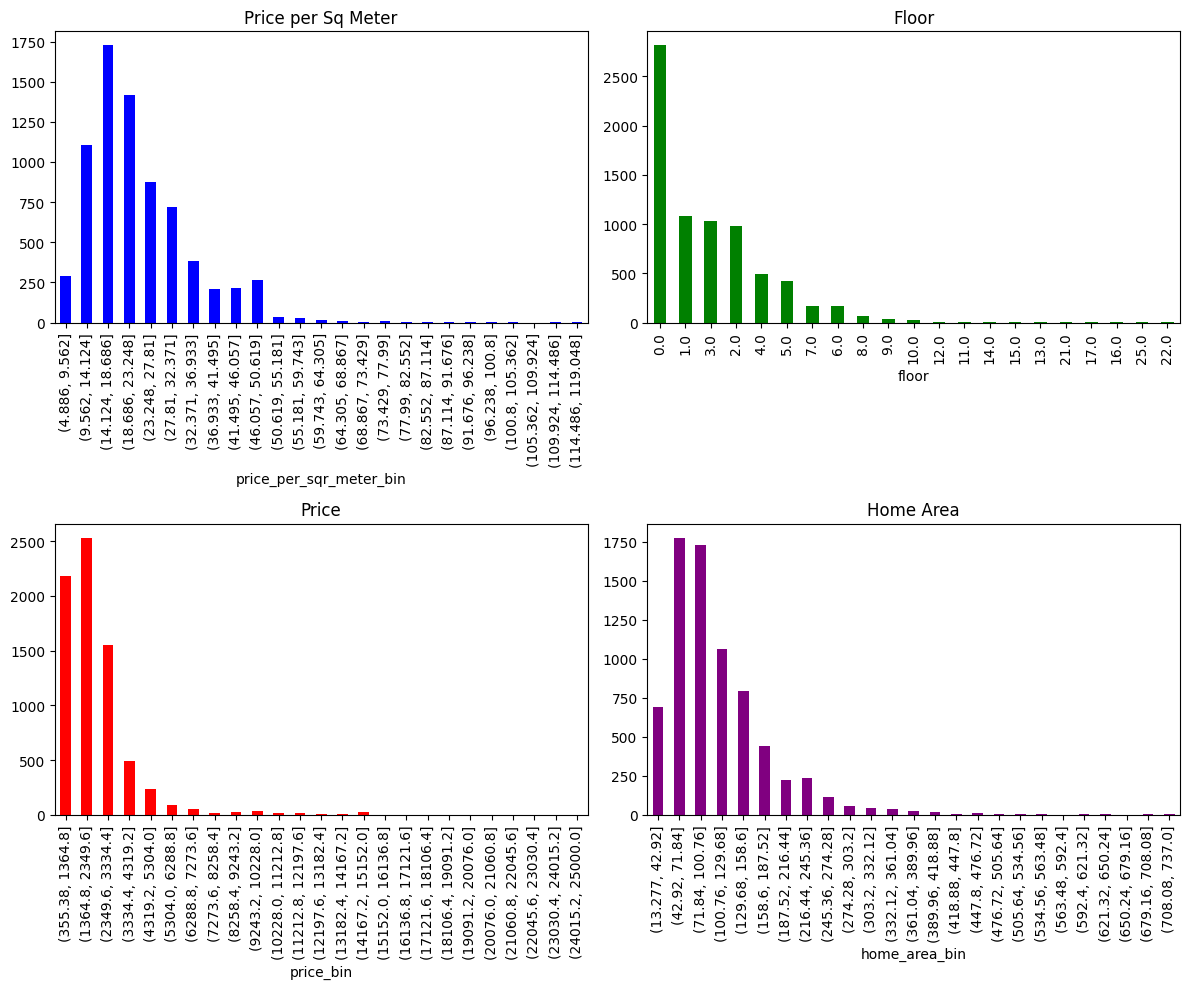

In [ ]:
plot_numeric(data, nbins = 25)

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the given text string by:
    - Stripping whitespace from start and end.
    - Converting all characters to lowercase.
    - Replacing accented characters with their closest ASCII counterparts.
    - Optionally: remove punctuation, digits, etc.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text.
    """

    # Normalize to a consistent form
    text = unicodedata.normalize('NFKD', text)

    # Strip whitespace
    text = text.strip()

    # Convert to lowercase
    text = text.lower()

    # Replace accented characters with ASCII equivalents
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove specific unwanted characters such as newlines and slashes
    text = re.sub(r'[\n/]', ' ', text)  # Replacing them with a space

    # Optionally: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Optionally: remove digits
    # text = re.sub(r'\d+', '', text)

    return text

In [ ]:
# remove stopwords from labels that do not have any meaning/value
def remove_stopwords(text):
    # Process the text
    doc = nlp(text)

    # Filter out stop words
    filtered_sentence = ' '.join([token.text for token in doc if not token.is_stop])   
    return filtered_sentence

In [ ]:
string_columns = ["title", "home_type", "neighborhood"] # i dont want to apply it to description

In [ ]:
for col in string_columns:
    data[col] = data[col].apply(preprocess_text)
    data[col] = data[col].apply(remove_stopwords)

display(data.head(5))

,title,home_type,link,garage,price,description,home_size,home_area,floor,elevator,price_per_sqr_meter,city,source,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin
0,apartamento t0 rua eleuterio teixeira 8 capari...,apartamento,https://www.idealista.pt/imovel/33394837/,No,1000,"Estúdio com muita luz, casa de banho com duche...",T0,50,0.0,False,20.000000,Almada,idealista,almada,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]"
1,apartamento t0 sao joao caparica costa caparica,apartamento,https://www.idealista.pt/imovel/33182313/,No,1250,"Apartamento T0, com vista de Mar.\nNão perca a...",T0,60,10.0,True,20.833333,Almada,idealista,costa caparica,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]"
2,apartamento t0 sao joao caparica costa caparica,apartamento,https://www.idealista.pt/imovel/33225472/,No,1200,Não perca a oportunidade de viver num apartame...,T0,57,6.0,True,21.052632,Almada,idealista,costa caparica,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]"
3,apartamento t0 avenida liberdade 5 caparica tr...,apartamento,https://www.idealista.pt/imovel/33132721/,No,1200,"Excelente apartamento t1 na Trafaria, a 2 minu...",T0,50,1.0,False,24.000000,Almada,idealista,almada,"(23.248, 27.81]","(355.38, 1364.8]","(42.92, 71.84]"
4,apartamento t1 almada,apartamento,https://www.idealista.pt/imovel/33394381/,No,918,Apartamento de tipologia T1 em prédio totalmen...,T1,55,0.0,False,16.690909,Almada,idealista,apartamento t1 almada,"(14.124, 18.686]","(355.38, 1364.8]","(42.92, 71.84]"


In [ ]:
def extract_street_names(text):
    # i want to remove these strings since they add not additional value
    context = set(list(data["home_type"].unique()) + list(data["home_size"].unique())) # doesnt work like this
    
    """Extract potential street names from a text string using spaCy's NER."""
    doc = nlp(text)
    # Customize entity labels based on observations and model performance
    street_entities = ['LOC', 'PROPN']
    street_names = [ent.text for ent in doc.ents if ent.label_ in street_entities and ent.text not in context]
    return ', '.join(street_names)

data['street_names'] = data['title'].apply(extract_street_names)
# replace "" values from the columns to the value of neighborhood
data['street_names'] = np.where(data['street_names'] == '', data['neighborhood'], data['street_names'])
agg_list = data.groupby('neighborhood')['street_names'].agg(list)

display(data["street_names"].nunique())
display(agg_list)

597

neighborhood
agualva mira   sintra             [sintra, rua pero escobar 1, sintra, rua luis ...
ajuda                             [ajuda, ajuda, ajuda, ajuda, ajuda, ajuda, aju...
alcabideche                       [alcabideche, alcabideche, alcabideche, alcabi...
alcantara                         [alto santo, alcantara, santo amaro, alto sant...
aldoar   foz douro   nevogilde    [aldoar   foz douro   nevogilde, aldoar   foz ...
                                                        ...                        
viana castelo                     [viana castelo, viana castelo, viana castelo, ...
viana castelo meadela             [viana castelo meadela, viana castelo meadela,...
vila gaia                         [vila gaia, vila gaia, vila gaia, vila gaia, v...
vilar andorinho                   [vilar andorinho, t2 vila, t2 vila, vilar ando...
viseu                             [viseu, viseu, viseu, viseu, viseu, viseu, rua...
Name: street_names, Length: 86, dtype: object

In [ ]:
from collections import Counter
from collections import OrderedDict

def count_elements(series):
    """ Returns a dictionary with the counts of each element in the list for each group. """

    return series.apply(Counter)

def sort_dict_by_values(d):
    """ Sort a dictionary by its values in descending order """

    return OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True))

street_name_counts = count_elements(agg_list)
street_name_counts = street_name_counts.apply(sort_dict_by_values)
display(street_name_counts)

neighborhood
agualva mira   sintra             {'sintra': 9, 'agualva mira   sintra': 2, 'rua...
ajuda                             {'ajuda': 66, 'dom vasco': 4, 'avenida helen k...
alcabideche                       {'alcabideche': 87, 'moradia independente zamb...
alcantara                         {'alcantara': 38, 'alto santo amaro, alcantara...
aldoar   foz douro   nevogilde    {'aldoar   foz douro   nevogilde': 129, 'pinha...
                                                        ...                        
viana castelo                     {'viana castelo': 14, 'moradia nogueira': 1, '...
viana castelo meadela             {'viana castelo meadela': 2, 'rua luis jacome ...
vila gaia                               {'vila gaia': 11, 'duplex rua 25 abril': 1}
vilar andorinho                   {'vilar andorinho': 4, 't2 vila': 2, 'duplex t...
viseu                             {'viseu': 32, 'avenida doutor antonio jose': 2...
Name: street_names, Length: 86, dtype: object

In [ ]:
grouped_data = data.groupby(["city", "neighborhood"])["street_names"].agg(list).reset_index()
# grouped_data.dropna(axis = 0).to_excel("cities.xlsx")
data.to_csv("preprocessed_data.csv")